In [1]:
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.datasets
from ipywidgets import interact

In [2]:
matplotlib.rcParams.update({'font.size': 18,
                            'lines.linewidth' : 3,
                           'figure.figsize' : [15, 5],
                           'lines.markersize': 10})
pd.options.mode.chained_assignment = None

# Model selection
<!-- requirement: images/ml_map.png -->

We have defined machine learning as the process of optimizing the cost function by tweaking the parameters of a model. We have defined a model as some map that uniquely maps input (features) to output (labels or target values). We've left this definition very vague, because there are many popular models used for machine learning. In this notebook we'll explore a few of them and investigate how to choose between different possible models.

In [3]:
from sklearn.datasets import fetch_california_housing

cali_data = fetch_california_housing()

cali_df = pd.DataFrame(cali_data.data, columns=cali_data.feature_names)
cali_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


We'll again work with the California data set, predicting home values based on the features. While this is a regression task, the concepts involved in model selection also apply to classification tasks, and many models are capable of both regression and classification.

## Exploratory analysis

Model selection begins with characterizing our data: 
- how many features are there?, 
- how many observations?, 
- are any features correlated?, 
- are the relationships between features and labels linear or nonlinear?, 
- is the variance in the features uniform, etc.? 


The `scikit-learn` documentation includes a [flowchart](http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) illustrating just some possible models and factors we might consider while we're exploring our data set.

![ml_model_flowchart](https://scikit-learn.org/stable/_static/ml_map.png)

In [4]:
def plot_feature(feature):
    plt.plot(cali_df[feature], cali_data.target, '.')
    plt.xlabel(feature)
    plt.ylabel('Median home value')

menu = cali_data.feature_names

interact(plot_feature, feature=menu);

interactive(children=(Dropdown(description='feature', options=('MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', …

The relationship between home value and some of the features looks very linear (e.g. median income), but others look non-linear or random (e.g. house age or geography). Let's try modeling one of the non-linear features.

## Decision Trees

A decision tree is essentially a logic tree that branches based on feature values.

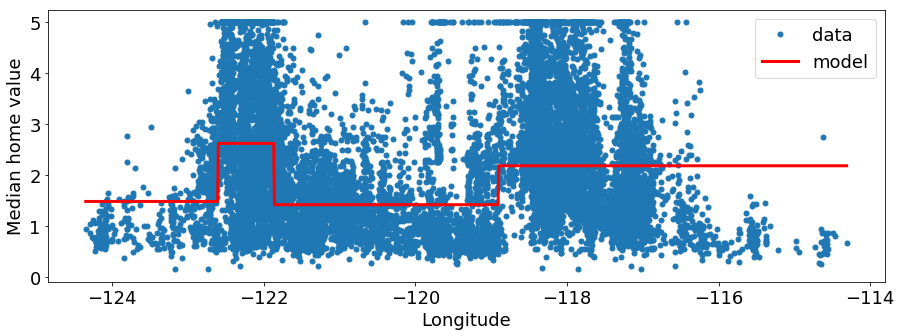

In [5]:
from sklearn import tree
from six import StringIO
from IPython import display
from graphviz import Source

model = tree.DecisionTreeRegressor(max_depth=2)
model.fit(cali_df['Longitude'].to_frame(), cali_data.target)

plt.plot(cali_df['Longitude'], cali_data.target, '.', label='data')
plt.plot(cali_df['Longitude'].sort_values(), 
         model.predict(cali_df['Longitude'].sort_values().to_frame()), 
         'r-', label='model')

plt.xlabel('Longitude')
plt.ylabel('Median home value')
plt.legend();

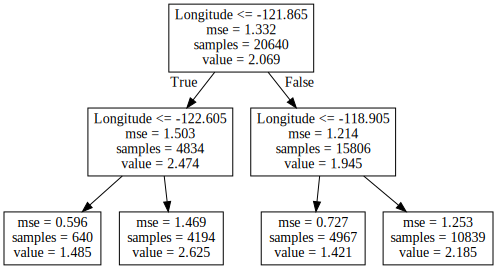

In [6]:
Source(tree.export_graphviz(model, out_file=None, feature_names=['Longitude']))

### Question
By allowing for more branching, we can make our model more complex. Does this make our model better or worse?

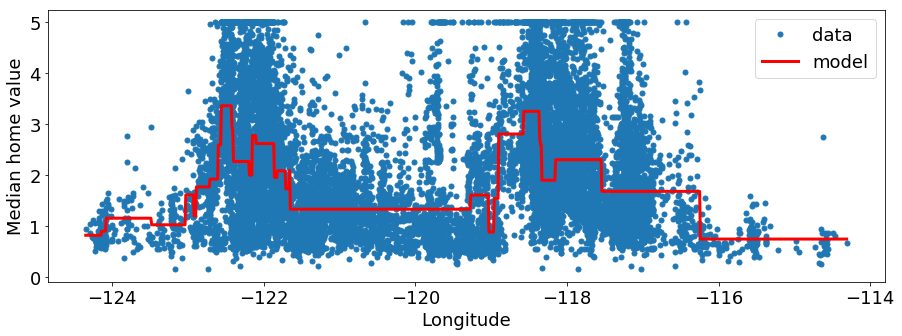

In [7]:
model = tree.DecisionTreeRegressor(max_depth=5)
model.fit(cali_df['Longitude'].to_frame(), cali_data.target)

plt.plot(cali_df['Longitude'], cali_data.target, '.', label='data')
plt.plot(cali_df['Longitude'].sort_values(), 
         model.predict(cali_df['Longitude'].sort_values().to_frame()), 
         'r-', label='model')

plt.xlabel('Longitude')
plt.ylabel('Median home value')
plt.legend();

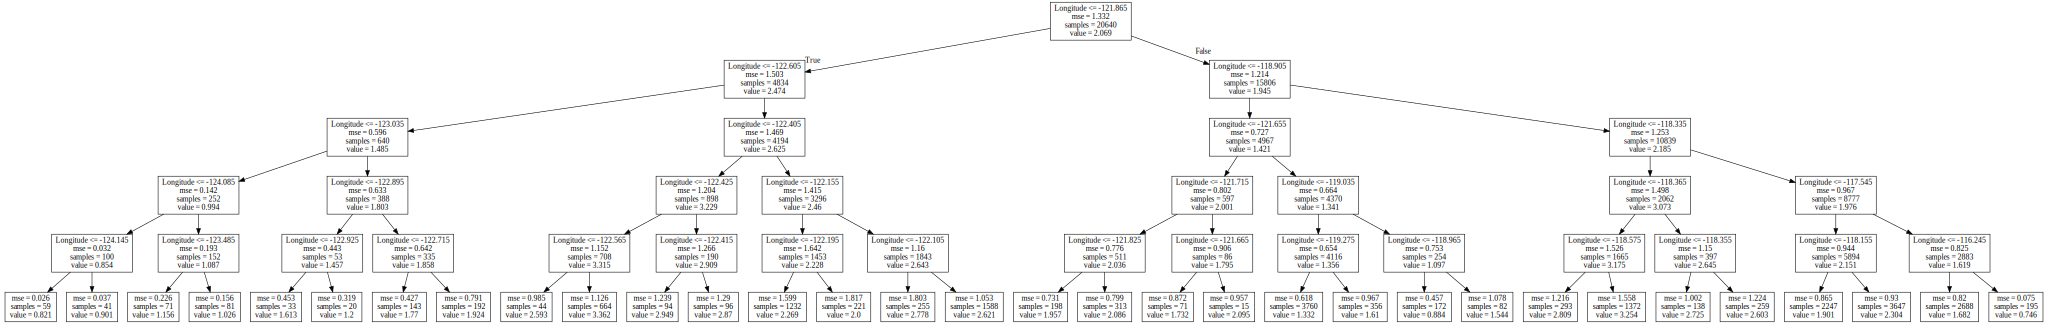

In [8]:
Source(tree.export_graphviz(model, out_file=None, feature_names=['Longitude']))

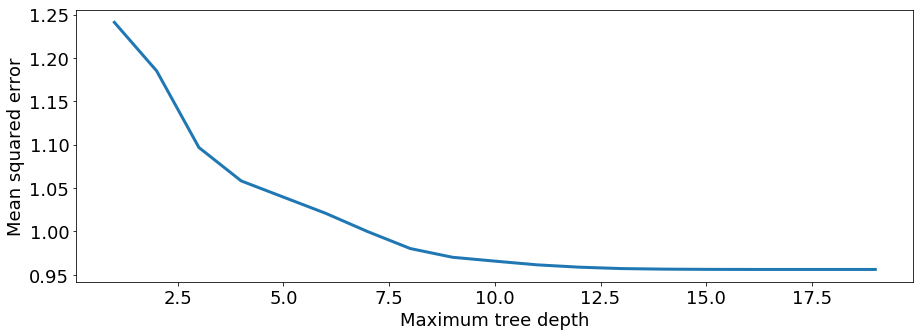

In [9]:
from sklearn.metrics import mean_squared_error as mse

max_depths = range(1, 20)
training_error = []
for max_depth in max_depths:
    model = tree.DecisionTreeRegressor(max_depth=max_depth)
    model.fit(cali_df['Latitude'].to_frame(), cali_data.target)
    training_error.append(mse(cali_data.target, model.predict(cali_df['Latitude'].to_frame())))

plt.plot(max_depths, training_error)
plt.xlabel('Maximum tree depth')
plt.ylabel('Mean squared error');

We reach a conflict: the model looks qualitatively worse beyond `max_depth > 5` but the error keeps dropping. This problem is called _overfitting_. The model looks worse because it doesn't follow the trend of the data, but instead follows the random noise. To detect overfitting, we need to see how our model generalizes to new data. We can do this artificially by withholding part of our data set during the training step, and then using it to test the model.

### Train-Test Split the data

**Question:**
- By allowing for more branching, we can make our model more complex. Does this make our model better or worse?

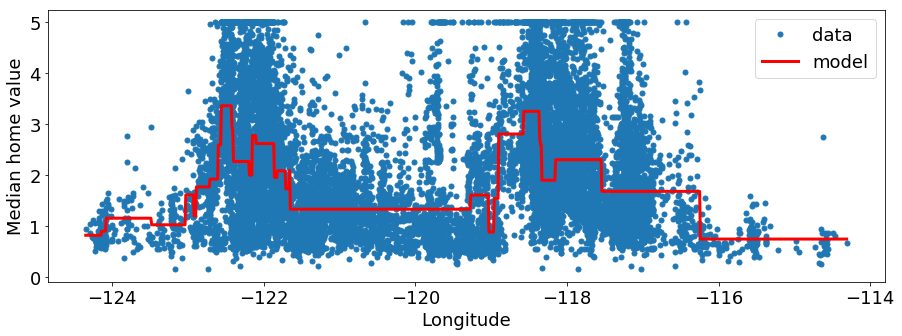

In [10]:
model = tree.DecisionTreeRegressor(max_depth=5)
model.fit(cali_df['Longitude'].to_frame(), cali_data.target)

plt.plot(cali_df['Longitude'], cali_data.target, '.', label='data')
plt.plot(cali_df['Longitude'].sort_values(), 
         model.predict(cali_df['Longitude'].sort_values().to_frame()), 
         'r-', label='model')

plt.xlabel('Longitude')
plt.ylabel('Median home value')
plt.legend();

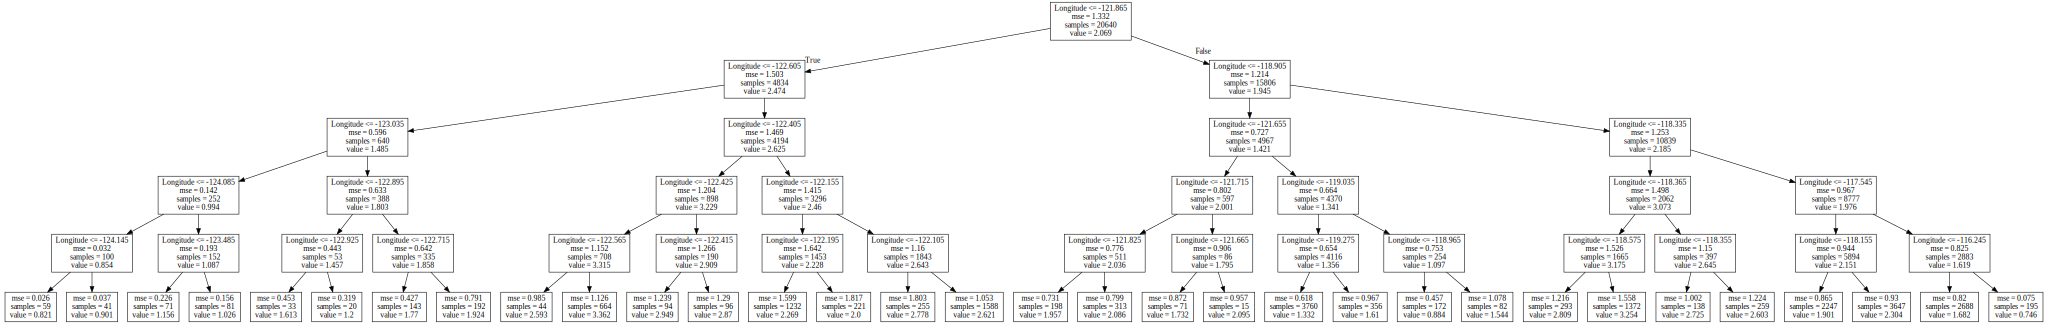

In [11]:
Source(tree.export_graphviz(model, out_file=None, feature_names=['Longitude']))

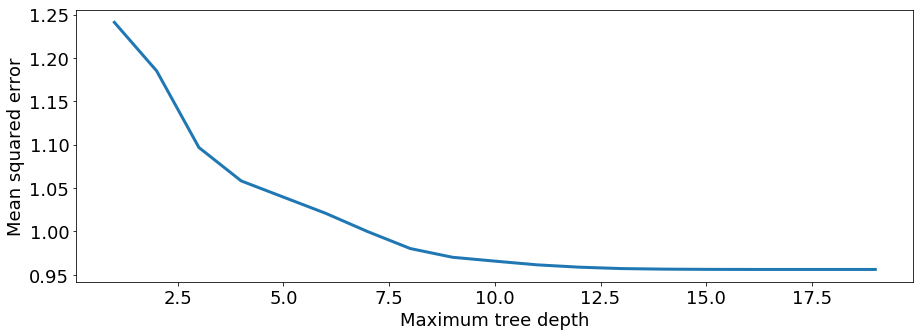

In [12]:
from sklearn.metrics import mean_squared_error as mse

max_depths = range(1, 20)
training_error = []
for max_depth in max_depths:
    model = tree.DecisionTreeRegressor(max_depth=max_depth)
    model.fit(cali_df['Latitude'].to_frame(), cali_data.target)
    training_error.append(mse(cali_data.target, model.predict(cali_df['Latitude'].to_frame())))

plt.plot(max_depths, training_error)
plt.xlabel('Maximum tree depth')
plt.ylabel('Mean squared error');

We reach a conflict: the model looks qualitatively worse beyond `max_depth > 5` but the error keeps dropping. This problem is called _overfitting_. The model looks worse because it doesn't follow the trend of the data, but instead follows the random noise. To detect overfitting, we need to see how our model generalizes to new data. We can do this artificially by withholding part of our data set during the training step, and then using it to test the model.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cali_df['Longitude'].to_frame(),
                                                    cali_data.target, test_size=0.1)

print(X_train.shape)
print(X_test.shape)

(18576, 1)
(2064, 1)


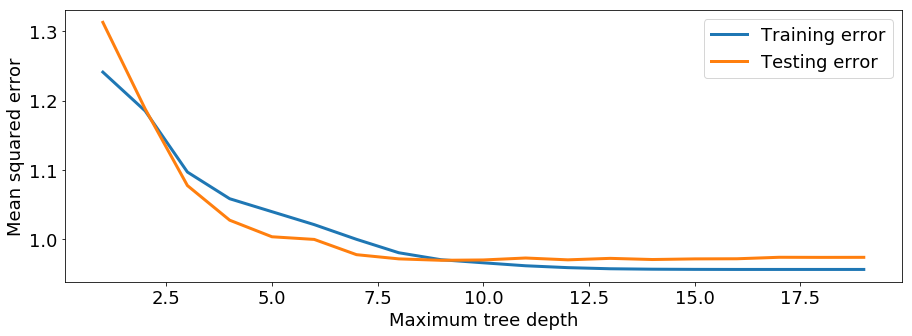

In [14]:
testing_error = []
for max_depth in max_depths:
    model = tree.DecisionTreeRegressor(max_depth=max_depth)
    model.fit(X_train, y_train)
    testing_error.append(mse(y_test, model.predict(X_test)))

plt.plot(max_depths, training_error, label='Training error')
plt.plot(max_depths, testing_error, label='Testing error')
plt.xlabel('Maximum tree depth')
plt.ylabel('Mean squared error')
plt.legend();

The testing error confirms our suspicion. As the model becomes more complex, it improves up to a point, and then it loses generalizability. One way to track complexity is the number of _parameters_ in our model. If we labeled each layer of our tree (starting with 0), we see there are $2^i$ parameters on layer $i$. Therefore the total number of parameters is $\sum_i 2**i$

In [15]:
list(zip(max_depths, [sum([2**i for i in range(max_depth)]) for max_depth in max_depths]))

[(1, 1),
 (2, 3),
 (3, 7),
 (4, 15),
 (5, 31),
 (6, 63),
 (7, 127),
 (8, 255),
 (9, 511),
 (10, 1023),
 (11, 2047),
 (12, 4095),
 (13, 8191),
 (14, 16383),
 (15, 32767),
 (16, 65535),
 (17, 131071),
 (18, 262143),
 (19, 524287)]

If we have enough parameters, we can simply memorize our training set, by creating a complex logical tree that separates all the different $X$ values in our training into unique branches of our tree. But _memorization is not learning_.

## Hyperparameters: tuning and cross-validation

When we defined our decision tree estimator, we chose how many layers the tree would have using the `max_depth` keyword. When we initiate an estimator, we can pass keyword arguments that will dictate its structure. The decision tree regressor accepts [12 different keyword arguments](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor). These arguments are called _hyperparameters_. This is in contrast to _parameters_, which are the the numbers that our model uses to predict labels based on features. _Parameters_ are optimized during training. _Hyperparameters_ are decided before training and dictate the model's structure. Basically all models have hyperparameters. Even a simple linear regressor has a hyperparameter `fit_intercept`.

Since changing hyperparameters changes the structure of the model, we should think of choosing hyperparameters as part of model selection. `Scikit-learn` provides a useful tool for comparing different hyperparameter values, `GridSearchCV`. There are two ideas behind `GridSearchCV`: first we will split up the data into a training and validation set (using a method called [k-folds](http://scikit-learn.org/stable/modules/cross_validation.html#k-fold)) and then we train and evaluate models with different hyperparameters selected from a grid of combinations.

In [16]:
from sklearn.model_selection import GridSearchCV

model = tree.DecisionTreeRegressor()

gs = GridSearchCV(model,
                  {'max_depth': range(1, 15),
                  'min_samples_split': range(10, 110, 10)},
                  cv=5,
                  n_jobs=2,
                  scoring='neg_mean_squared_error')

gs.fit(X_train, y_train)

print(gs.best_params_)

{'max_depth': 9, 'min_samples_split': 100}


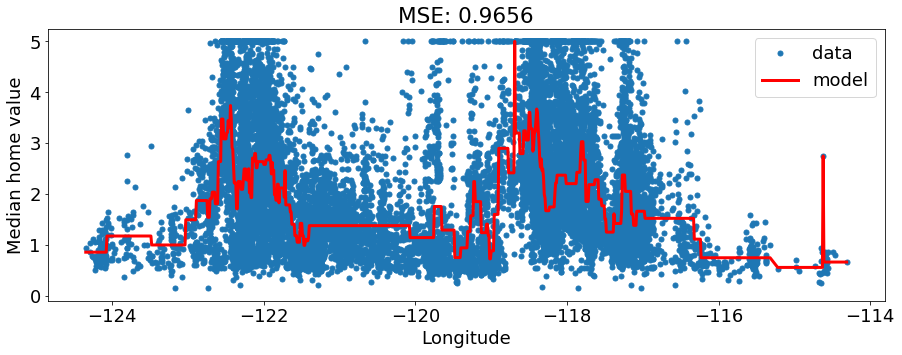

In [17]:
model = gs.best_estimator_
model.fit(X_train, y_train)

plt.plot(cali_df['Longitude'], cali_data.target, '.', label='data')
plt.plot(cali_df['Longitude'].sort_values(), model.predict(cali_df['Longitude'].sort_values().to_frame()), 'r-', label='model')
plt.xlabel('Longitude')
plt.ylabel('Median home value')
plt.title('MSE: {0:.4f}'.format(mse(y_test, model.predict(X_test))))
plt.legend();

## Comparing different estimators

`Scikit-learn`'s `GridSearchCV` only takes one estimator, so while it is useful for hyperparameter tuning, we can't use it to compare different estimators. However, we could easily iterate over different estimators, tune their hyperparameters using `GridSearchCV`, and use a metric to compare their performance.

For example, K-Neighbors is a very flexible model that uses the k-nearest points in feature space to predict the value of a new observation. Will this perform better than our decision tree?

In [18]:
from sklearn.neighbors import KNeighborsRegressor

tree_reg = tree.DecisionTreeRegressor()
knn_reg = KNeighborsRegressor()

estimators = {'tree_reg': tree_reg, 
              'knn_reg': knn_reg}
hyperparam_dict = {'tree_reg': {'min_samples_split': range(10, 110, 10), 'max_depth': range(1, 15)}, 
                   'knn_reg': {'n_neighbors': range(10, 100, 10)}
                  }

scores = {}
for name, estimator in estimators.items():
    gs = GridSearchCV(estimator,
                      hyperparam_dict[name],
                      cv=5,
                      n_jobs=2,
                      scoring='neg_mean_squared_error')
    
    gs.fit(X_train, y_train)

    scores[name] = -gs.best_score_

print(scores)

{'tree_reg': 0.9291016394427742, 'knn_reg': 0.920244462614654}


# Feature engineering
Our models can't reveal structure in our data when no structure exists. Consider the following data:

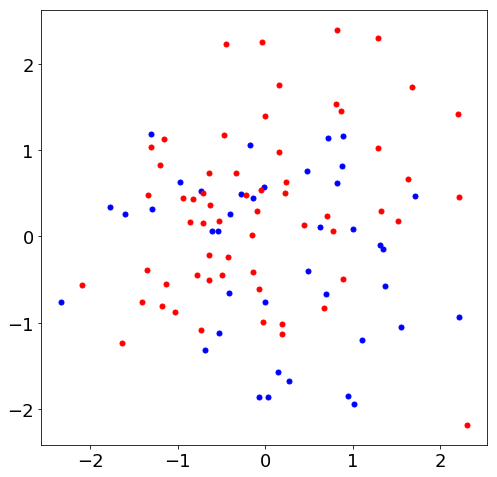

In [19]:
x1 = np.random.randn(100)
x2 = np.random.randn(100)
y = np.random.choice([True, False], size=100)

plt.figure(figsize=(8,8))
plt.plot(x1[y], x2[y], 'b.')
plt.plot(x1[~y], x2[~y], 'r.');

In [20]:
random_df = pd.DataFrame(np.vstack([x1, x2, y]).T, columns=['x1', 'x2', 'y'])
random_df.head()

,x1,x2,y
0,-0.642486,-0.220452,0.0
1,1.678027,1.735193,0.0
2,-0.781675,-0.443820,0.0
3,-0.854532,0.164963,0.0
4,0.033156,-1.858073,1.0


In [21]:
random_df.corr()

,x1,x2,y
x1,1.000000,0.049983,0.100519
x2,0.049983,1.000000,-0.256344
y,0.100519,-0.256344,1.000000


Beyond the choice of features to measure and how much data to collect (which we often can't control), there are many techniques for transforming our data set to amplify the most useful information for our machine learning models. Some of these techniques operate on the data directly while others are modifications to how we train our estimator. Such techniques are collectively called _feature engineering_.

## Feature extraction

Machine learning algorithm require observations to be vectors of features. Sometimes our raw data will not be a vector of features or a vector at all. For example, our data might be a collection of images. We could flatten the image into a vector, but this destroys important spatial relationships in the data. Our data could be a string of text like a news article. A string is linear, but doesn't have fixed length, and it's not immediately clear how to represent text as numbers. Our data could be several years of commodity price data, which is a vector of numbers, but it may be better represented in an aggregated form instead of a raw time-series.

In cases like these we have the privilege of constructing features, giving us maximum control over preparation of the data (without actually deciding how raw data gets collected). Feature extraction will often be specific to the data set, but some things to think about include:

- What counts as an observation in the raw data?
- Are there spatial or temporal relationships within the data of a single observation?
- If my data aren't numbers, what is the most meaningful way to transform the data into numbers?
- If my data are numbers, are the raw values most meaningful? Differences between raw values? Other transformations or aggregations?

Let's work through an example to illustrate some of these concepts.

In [22]:
temps = pd.read_csv('./00_data/land_temps_by_city.csv', parse_dates=[0])
temps.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1900-02-01,0.969,0.585,Berlin,Germany,52.24N,13.14E
1,1900-03-01,1.313,0.328,Berlin,Germany,52.24N,13.14E
2,1900-04-01,7.246,0.317,Berlin,Germany,52.24N,13.14E
3,1900-05-01,12.125,0.240,Berlin,Germany,52.24N,13.14E
4,1900-06-01,17.362,0.343,Berlin,Germany,52.24N,13.14E


We have temperature data for many cities around the world. If we were making predictions about the climate of these different cities, it may be more useful to summarize the temperature data in a quantity that characterizes the different climates. For example, some of these cities have 4 seasons while others do not. We might see this reflected in how the temperatures correlate with each other over the course of the year.

In [23]:
from functools import reduce
def collect(x):
    return reduce(lambda y, z: y + [z] if isinstance(y, list) else [z], x)

def estimated_autocorrelation(x):
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')[-n:]
    result = r/(variance*(np.arange(n, 0, -1)))
    return result

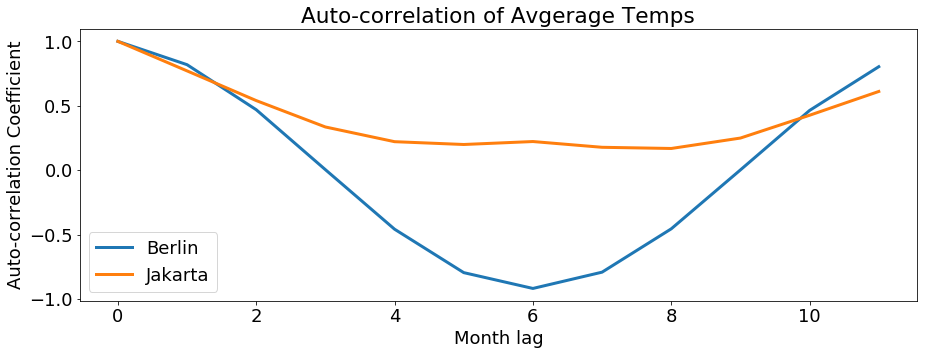

In [24]:
plt.plot(estimated_autocorrelation(temps[temps['City']=='Berlin']['AverageTemperature'].values)[:12], label='Berlin')
plt.plot(estimated_autocorrelation(temps[temps['City']=='Jakarta']['AverageTemperature'].values)[:12], label='Jakarta')
plt.title('Auto-correlation of Avgerage Temps')
plt.xlabel('Month lag')
plt.ylabel('Auto-correlation Coefficient')
plt.legend();

Looking at these graphs, we can see that the temperature in Berlin six months in the future mirrors the temperature in Berlin today (correlation $\approx$ -1). However, in Jakarta, the average temperature six months in the future is basically unrelated to the temperature today (correlation $\approx$ 0). This indicates a different seasonality, associated with their different climates. We can extract the six-month autocorrelation value as a feature for each city's climate.

In [25]:
ac = temps.groupby('City')['AverageTemperature'].apply(collect).apply(lambda x: np.array(x)).apply(estimated_autocorrelation).rename('autocorr')
ac_lat = pd.concat([ac.apply(lambda x: x[range(6, 1362, 12)].mean()), temps[['City', 'Latitude']].drop_duplicates().set_index('City')], axis=1)
ac_lat['Latitude'] = ac_lat['Latitude'].apply(lambda x: float(x[:-1]))

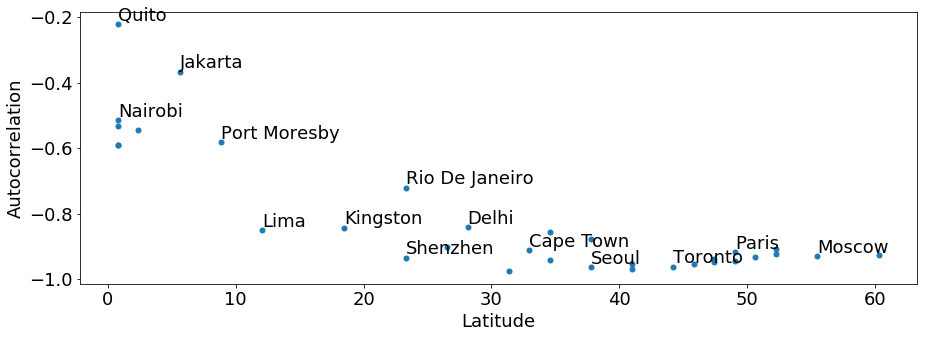

In [26]:
plt.plot(ac_lat['Latitude'], ac_lat['autocorr'], '.')
plt.xlabel("Latitude")
plt.ylabel("Autocorrelation")
ax = plt.gca()
labels = {'Lima', 'Shenzhen', 'Delhi', 'Lima', 'Kingston', 'Cape Town', 'Jakarta', 'Nairobi', 'Rio De Janeiro', 'Quito', 'Port Moresby', 'Seoul', 'Moscow', 'Paris', 'Toronto'}
for city in ac_lat.index:
    if city in labels:
        plt.text(ac_lat.loc[city, 'Latitude'], ac_lat.loc[city, 'autocorr'] + .01, city)

## Feature transformations

Sometimes our observations will be very unevenly distributed for a given feature. For example, income is roughly exponentially distributed in many populations. Sometimes the relationship between a feature and a regression target follows a clear non-linear trend. In cases like these it can be useful to transform the values of our features or our target to better highlight trends or to allow for use of models that might not otherwise be applicable.

For example, we could fit a line to the relationship between latitude and 6-month autocorrelation in temperature, but it wouldn't be a great fit.

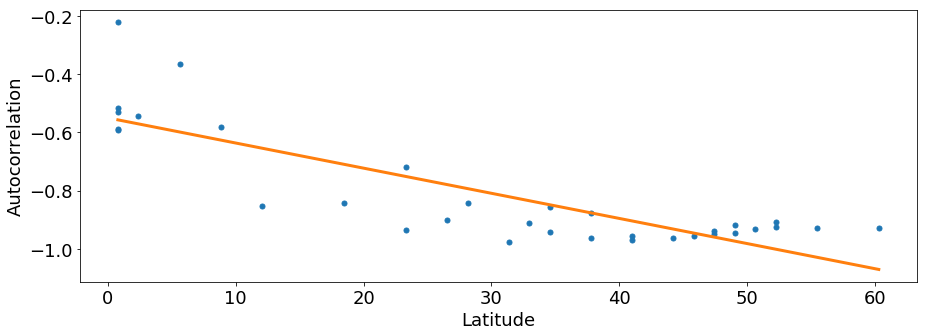

In [27]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression().fit(ac_lat['Latitude'].values.reshape(-1, 1), ac_lat['autocorr'].values.reshape(-1, 1))

ac_lat.sort_values('Latitude', inplace=True)

plt.plot(ac_lat['Latitude'], ac_lat['autocorr'], '.')
plt.plot(ac_lat['Latitude'], lin_reg.predict(ac_lat['Latitude'].values.reshape(-1, 1)))
plt.xlabel('Latitude')
plt.ylabel("Autocorrelation");

However, this data looks roughly like $y = e^{-x/\lambda} - 1$. If we substituted the variable $u = e^{-x/\lambda}$, we would have $y \propto u$, a linear relationship.

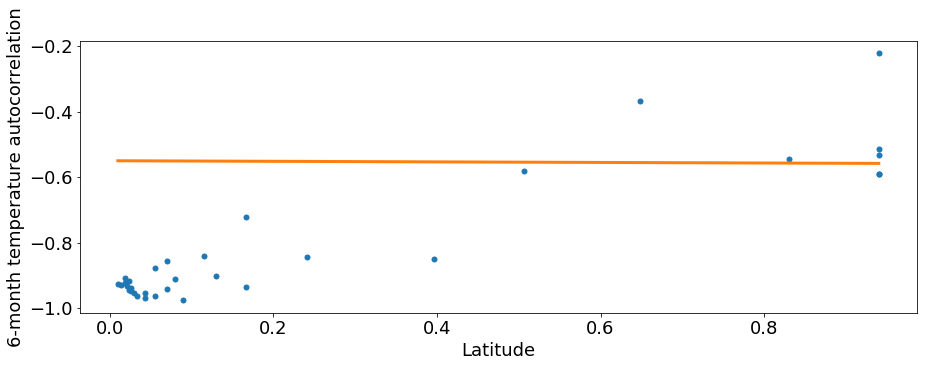

In [28]:
plt.plot(np.exp(-ac_lat['Latitude']/13), ac_lat['autocorr'], '.')
plt.plot(np.exp(-ac_lat['Latitude']/13), lin_reg.predict(np.exp(-ac_lat['Latitude']/13).values.reshape(-1, 1)))
plt.xlabel('Latitude')
plt.ylabel('6-month temperature autocorrelation');

This looks somewhat more linear. We could fit a linear model to this transformed feature.

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.utils import shuffle

X_train, X_test, y_train, y_test = train_test_split(*shuffle(ac_lat['Latitude'].values.reshape(-1, 1), 
                                                             ac_lat['autocorr'].values.reshape(-1, 1),
                                                            random_state=8), 
                                                    test_size=0.1)

lin_reg = LinearRegression()
lin_reg.fit(np.exp(-X_train/13), y_train)
lin_pred = lin_reg.predict(np.exp(-X_test/13))

Let's compare the result with a decision tree applied to the untransformed data.

In [45]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=3)
tree_reg.fit(X_train, y_train)
tree_pred = tree_reg.predict(X_test)

Transformed linear regression MSE: 0.02
Decision tree regression MSE: 0.02


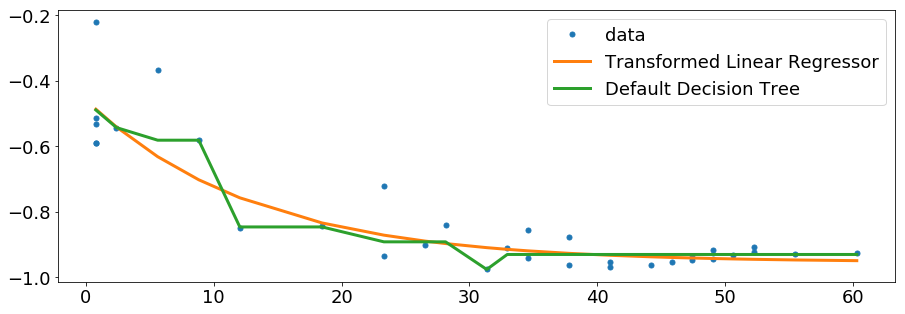

In [31]:
ac_lat.sort_values('Latitude', inplace=True)

plt.plot(ac_lat['Latitude'], ac_lat['autocorr'], '.', label='data')
plt.plot(ac_lat['Latitude'], lin_reg.predict(np.exp(-ac_lat['Latitude'].values.reshape(-1, 1) / 13)), label='Transformed Linear Regressor')
plt.plot(ac_lat['Latitude'], tree_reg.predict(ac_lat['Latitude'].values.reshape(-1, 1)), label='Default Decision Tree')
plt.legend();

print('Transformed linear regression MSE: %0.2f' % mse(y_test, lin_pred))
print('Decision tree regression MSE: %0.2f' % mse(y_test, tree_pred))

## Curse of dimensionality

It is easy to see why adding features to a data set might be helpful.

In [32]:
n = 1000
x1 = np.concatenate([np.random.randn(n // 2), np.random.randn(n // 2) + 2])
y = np.array([True if i < n // 2 else False for i in range(n)])
x2 = np.concatenate([np.random.randn(n // 2), np.random.randn(n // 2) + 2])

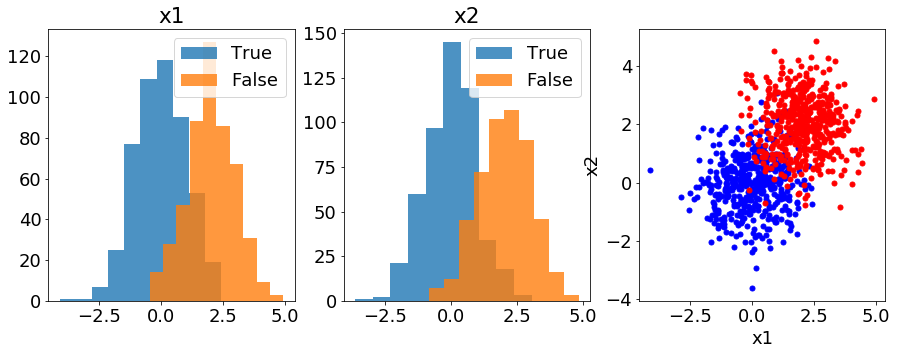

In [33]:
fig, ax = plt.subplots(ncols=3)
ax[0].hist(x1[y], alpha=.8, label='True')
ax[0].hist(x1[~y], alpha=.8, label='False')
ax[0].set_title('x1')
ax[0].legend()
ax[1].hist(x2[y], alpha=.8, label='True')
ax[1].hist(x2[~y], alpha=.8, label='False')
ax[1].set_title('x2')
ax[1].legend()
ax[2].plot(x1[y], x2[y], 'b.')
ax[2].plot(x1[~y], x2[~y], 'r.')
ax[2].set_xlabel('x1')
ax[2].set_ylabel('x2')
plt.show();

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(np.vstack([x1, x2]).T, y)

# Fit LR using only x1
log_reg_1d = LogisticRegression(solver='lbfgs').fit(np.atleast_2d(X_train[:, 0]).T, y_train)
# Fit LR using both x1 and x2
log_reg_2d = LogisticRegression(solver='lbfgs').fit(X_train, y_train)

print('Score on 1D data: %0.2f' % accuracy_score(y_test, log_reg_1d.predict(np.atleast_2d(X_test[:, 0]).T)))
print('Score on 2D data: %0.2f' % accuracy_score(y_test, log_reg_2d.predict(X_test)))

Score on 1D data: 0.86
Score on 2D data: 0.92


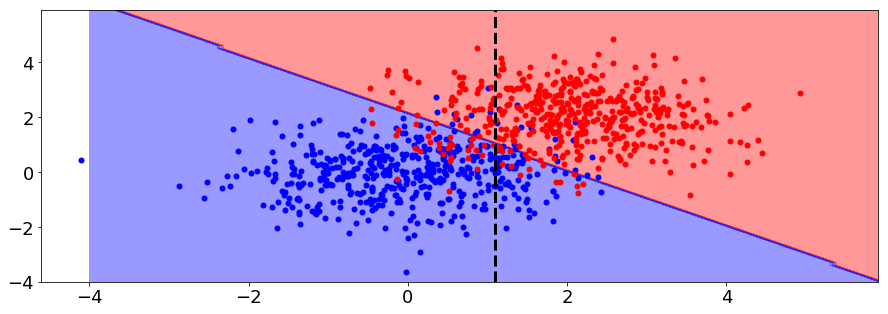

In [35]:
from matplotlib.colors import ListedColormap

xx1, xx2 = np.meshgrid(np.arange(-4, 6, .1), np.arange(-4, 6, .1))

Z = log_reg_2d.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
Z = Z.reshape(xx1.shape)

cut_1d = np.arange(-4, 6, .1)[log_reg_1d.predict_proba(np.atleast_2d(np.arange(-4,6,.1)).T)[:, 0] > .5][0]

colors = ('red', 'blue')
cmap = ListedColormap(colors)

plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
plt.plot(x1[y], x2[y], 'b.')
plt.plot(x1[~y], x2[~y], 'r.')
plt.axvline(cut_1d, color='k', linestyle='--');

However, as we increase the dimensionality of our data by adding more features, the data gets more spread out. If the data is very high dimensional, it may be too spread out to identify any trends or clusters. This is know as the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). As we increase the number of features, we will generally require more observations to ensure good sampling density throughout feature space.

## Feature importance and selection

To avoid the curse of dimensionality, we'll sometimes want to reduce the dimensionality of our data. We may also want to reduce the dimensionality of our data simply to compress it (in the case of very large data) or simply to visualize the data. Reducing dimensionality also helps make models more interpretable. When reducing the dimensionality of the data, we will want to get rid of irrelevant or redundant features.

There are a number of ways to assess feature importance. Let's work again with the California housing data set.

In [36]:
from sklearn.datasets import fetch_california_housing

cali_data = fetch_california_housing()

cali_df = pd.DataFrame(cali_data.data, columns=cali_data.feature_names)

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
import scipy.stats

X_train, X_test, y_train, y_test = train_test_split(cali_df, cali_data.target, test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

model = DecisionTreeRegressor()

rs = RandomizedSearchCV(model,
                  {'max_depth': scipy.stats.binom(9, .3, loc=1),
                  'min_samples_split': scipy.stats.binom(90, .5, loc=10)},
                   cv=5,
                   n_iter=200,
                   n_jobs=4,
                   scoring='neg_mean_squared_error')

rs.fit(X_train, y_train)
print('R^2 (coefficient of determination) regression score: {}'.format(r2_score(y_test, rs.best_estimator_.predict(scaler.transform(X_test)))))

print('Feature Importance:')
list(zip(cali_data.feature_names, rs.best_estimator_.feature_importances_))

R^2 (coefficient of determination) regression score: 0.682998891205622
Feature Importance:


[('MedInc', 0.7058739136987366),
 ('HouseAge', 0.044556471043053415),
 ('AveRooms', 0.033769097564888474),
 ('AveBedrms', 0.002242169682354362),
 ('Population', 0.007059056496613231),
 ('AveOccup', 0.13639288256706458),
 ('Latitude', 0.04202314580594178),
 ('Longitude', 0.028083263141347545)]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(cali_df, cali_data.target, test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

lin_reg = LinearRegression().fit(X_train, y_train)

print('R^2 (coefficient of determination) regression score: {}'.format(r2_score(y_test, lin_reg.predict(scaler.transform(X_test)))))

print('Feature Importance:')
list(zip(cali_data.feature_names, abs(lin_reg.coef_) / sum(abs(lin_reg.coef_))))

R^2 (coefficient of determination) regression score: 0.6187580962163942
Feature Importance:


[('MedInc', 0.2487330633843214),
 ('HouseAge', 0.03443652692877176),
 ('AveRooms', 0.08143319242517345),
 ('AveBedrms', 0.093225198772164),
 ('Population', 0.0019351663634271951),
 ('AveOccup', 0.011768823230619483),
 ('Latitude', 0.26886170752544314),
 ('Longitude', 0.25960632137007966)]

The `feature_selection` submodule of Scikit-learn provides [some useful tools](http://scikit-learn.org/stable/modules/feature_selection.html) for discarding unimportant features.

## Regularization

When we have too many features, our observations become sparse, making it hard to detect trends in the data. Our model begins to simply memorize the training set based on the many features. We can also say our model is fitting _noise_ instead of trend, because small random variations across many features results in observations being very separated.

One way to limit overfitting due to high dimensionality is _regularization_. To regularize a model, we introduce a penalty in the cost function associated with the values of model parameters themselves. For example, we could regularize our linear regression model by changing the cost function.

$$ C({\Theta_i}) = \sum_j (y_j - X_{ij}\Theta_i)^2 \Longrightarrow
C({\Theta_i}) = \sum_j (y_j - X_{ij}\Theta_i)^2 + \alpha\sum_i\Theta_i^2 $$

The new cost function will tend to reduce the values of model parameters, limiting the effect of unimportant features. We could choose other penalties (e.g. $\alpha\sum_i\|\Theta_i\|$) to change the effects of regularization.

In [39]:
from sklearn.linear_model import Ridge, Lasso
X_train, X_test, y_train, y_test = train_test_split(cali_df, cali_data.target, test_size=0.1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

lin_reg = LinearRegression().fit(X_train, y_train)

alphas = np.logspace(-2, 2, 100)
ridge_coefs = []
ridge_scores = []
lasso_coefs = []
lasso_scores = []
for alpha in alphas:
    ridge_reg = Ridge(alpha=alpha).fit(X_train, y_train)
    ridge_coefs.append(ridge_reg.coef_)
    ridge_scores.append(r2_score(y_test, ridge_reg.predict(scaler.transform(X_test))))
    lasso_reg = Lasso(alpha=alpha).fit(X_train, y_train)
    lasso_coefs.append(lasso_reg.coef_)
    lasso_scores.append(r2_score(y_test, lasso_reg.predict(scaler.transform(X_test))))

lin_score = r2_score(y_test, lin_reg.predict(scaler.transform(X_test)))
print('Linear regression score: %0.2f' % lin_score)
print('Ridge regression score: %0.2f' % max(ridge_scores))
print('Lasso regression score: %0.2f' % max(lasso_scores))

Linear regression score: 0.61
Ridge regression score: 0.61
Lasso regression score: 0.61


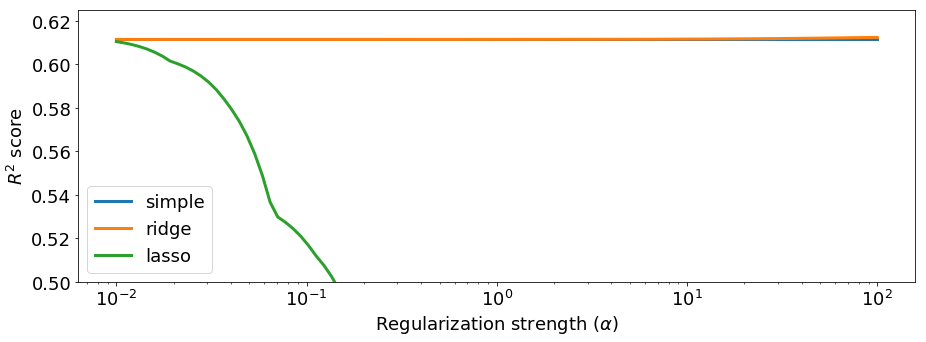

In [40]:
plt.figure()
plt.gca().set_xscale('log')
plt.gca().set_ylim([.5, .625])
plt.plot(alphas, np.repeat(lin_score, len(alphas)), label='simple')
plt.plot(alphas, ridge_scores, label='ridge')
plt.plot(alphas, lasso_scores, label='lasso')
plt.xlabel(r'Regularization strength ($\alpha$)')
plt.ylabel(r'$R^2$ score')
plt.legend();

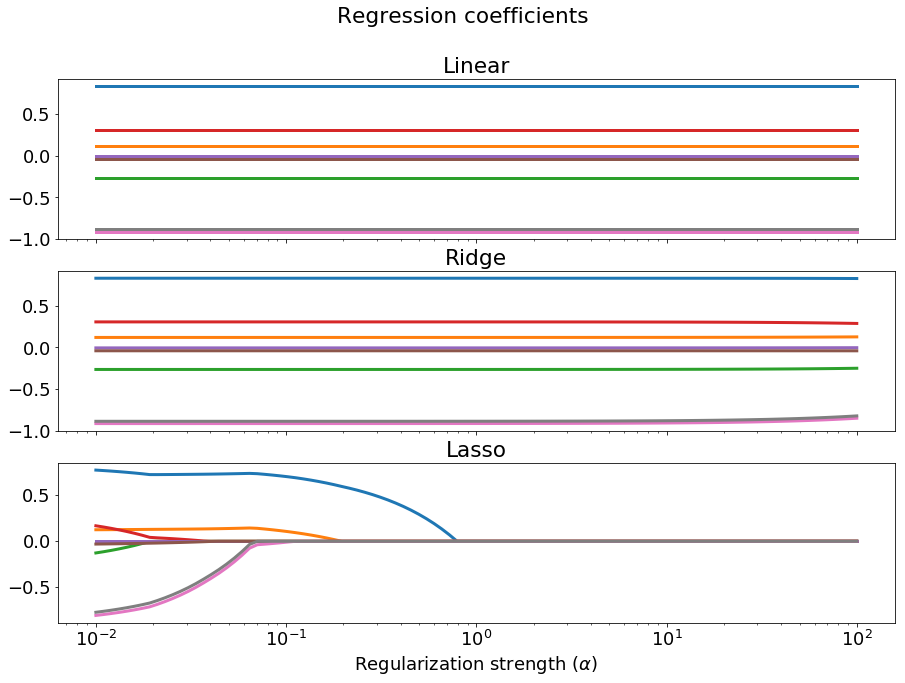

In [41]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(15,10))
fig.suptitle('Regression coefficients')

ax[0].set_xscale('log')
# plt.ylabel
for coef in lin_reg.coef_:
    ax[0].plot(alphas, np.repeat(coef, len(alphas)))
    ax[0].set_title('Linear')

ax[1].plot(alphas, ridge_coefs)
ax[1].set_title('Ridge')

ax[2].plot(alphas, lasso_coefs, label='Lasso')
ax[2].set_title('Lasso')
ax[2].set_xlabel(r'Regularization strength ($\alpha$)');


In [42]:
x = 15
print(alphas[x], lasso_scores[x])
list(zip(cali_data.feature_names, lasso_coefs[x]))

0.040370172585965536 0.5792205152871008


[('MedInc', 0.7302753782398714),
 ('HouseAge', 0.13562837210834952),
 ('AveRooms', -0.0),
 ('AveBedrms', 0.0),
 ('Population', -0.0),
 ('AveOccup', -0.0014500252601154025),
 ('Latitude', -0.40205732827510643),
 ('Longitude', -0.36154276015866116)]

## Correlation between features and multicollinearity

Sometimes our features may be closely related to other features. We can easily calculate the correlation coefficient between pairs of features.

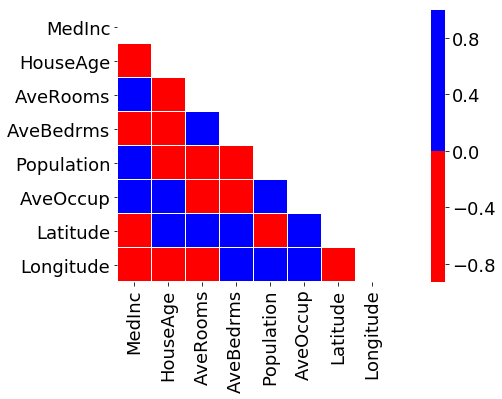

In [62]:
corr = cali_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

#cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, linewidths=.5, center=0, vmax=1);

Correlation can be an indicator of feature redundancy. In particular if a feature can be approximated as a linear combination of other features

$$ X_j \approx \sum_{i \ne j}\beta_{ij}X_i $$

we say our features are multicollinear. Multicollinearity can introduce instability into our regression model parameters, making model interpretation difficult. Furthermore, features that are linear combinations of other features are redundant.

## Principal component analysis

So far we have explored techniques for identifying unimportant or redundant features and ways to eliminate them from our data or model. When we eliminate features from our data, even if they are correlated with other features, we lose information.

One way to mitigate the loss of information is to combine our $n$ original features into $m$ new features, with $m < n$. We can calculate what combinations preserve the most information using **principal component analysis** (PCA).

Let's look back to an earlier example to understand how this works. We found earlier that adding a second feature to a data set helped us gain predictive power to separate two classes.

In [46]:
from ipywidgets import interact

def plot_data(rotation=0):
    x1_r = x1 * np.cos(rotation) + x2 * np.sin(rotation)
    x2_r = -x1 * np.sin(rotation) + x2 * np.cos(rotation)
    plt.plot(x1_r[y], x2_r[y], 'b.')
    plt.plot(x1_r[~y], x2_r[~y], 'r.')

    w1, w2 = log_reg_2d.coef_[0]
    x = np.sort(x1)
    line = (-log_reg_2d.intercept_ - w1 * x) / w2
    x_r = x * np.cos(rotation) + line * np.sin(rotation)
    line_r = -x * np.sin(rotation) + line * np.cos(rotation)
    plt.plot(x_r, line_r)
    
interact(plot_data, rotation=(0, np.pi, .1));

interactive(children=(FloatSlider(value=0.0, description='rotation', max=3.141592653589793), Output()), _dom_c…

After rotating the data, we see that we could reduce the data from two dimensions to one without losing any important information. Principal component analysis projects the data into a lower dimensional space, choosing the projection by maximizing the variance in the projected data. Usually this is the optimal choice.

In [52]:
from sklearn.decomposition import PCA

X_train, X_test, y_train, y_test = train_test_split(np.vstack([x1, x2]).T, y)

pca = PCA(n_components=1)
X_pca_train = pca.fit_transform(X_train)
X_pca_test = pca.transform(X_test)

log_reg_pca = LogisticRegression(solver='lbfgs').fit(X_pca_train, y_train)

print('Score on 2D data: %0.2f' % accuracy_score(y_test, log_reg_2d.predict(X_test)))
print('Score on 1D data (PCA): %0.2f' % accuracy_score(y_test, log_reg_pca.predict(X_pca_test)))

Score on 2D data: 0.93
Score on 1D data (PCA): 0.93
